# Билет 20

## Задание 2

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


Загрузка и обработка данных

In [62]:
house_df = pd.read_csv("../data/regression/house.csv")
print(house_df.shape)
house_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [63]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

1460 примеров, 80 признаков, целевая переменная - `SalePrice` - задача предсказать `SalePrice` по заданным признакам.

Пропусков в выборке нет.

Первая модель со всеми колонками получилась плохая, попробую эмпирически взять несколько:

In [64]:
house_df = house_df[[
    "SalePrice",  # target
    "OverallQual",
    "GrLivArea",
    "TotalBsmtSF",
    "GarageCars",
    "BsmtFinSF1",
    "Fireplaces",
    "Foundation",
    "BsmtQual",
    "KitchenQual",
    "WoodDeckSF",
    "LotShape",
    "Neighborhood",
    "HouseStyle",
    "SaleCondition",
]]

Удалим дубликаты:

In [65]:
len(house_df[house_df.duplicated()])
house_df = house_df.drop_duplicates()
house_df[house_df.duplicated()].value_counts()

Series([], dtype: int64)

Посмотрим на категориальные данные:

In [66]:
house_df[house_df.select_dtypes(object).columns].nunique()

Foundation        6
BsmtQual          5
KitchenQual       4
LotShape          4
Neighborhood     25
HouseStyle        8
SaleCondition     6
dtype: int64

In [67]:
print(house_df.shape)
house_df.head()

(1459, 15)


,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,BsmtFinSF1,Fireplaces,Foundation,BsmtQual,KitchenQual,WoodDeckSF,LotShape,Neighborhood,HouseStyle,SaleCondition
0,208500,7,1710,856,2,706,0,PConc,Gd,Gd,0,Reg,CollgCr,2Story,Normal
1,181500,6,1262,1262,2,978,1,CBlock,Gd,TA,298,Reg,Veenker,1Story,Normal
2,223500,7,1786,920,2,486,1,PConc,Gd,Gd,0,IR1,CollgCr,2Story,Normal
3,140000,7,1717,756,3,216,1,BrkTil,TA,Gd,0,IR1,Crawfor,2Story,Abnorml
4,250000,8,2198,1145,3,655,1,PConc,Gd,Gd,192,IR1,NoRidge,2Story,Normal


Реализует Dataset для удобной работы с DataLoader:

In [68]:
class HouseDataset(Dataset):

    def __init__(self, df, encoder=None, scaler=None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:  # учимся только на тренировочной выборке
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:  # учимся только на тренировочной выборке
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        data, targets = df.drop(columns=["SalePrice"]), df["SalePrice"]

        data = scale(encode(data))  # да, необязательно кодировать только категориальные колонки
        self.data = torch.tensor(data, dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

Разделю данные на обучающую 80% и тестовую 20% выборки:

In [69]:
train_df, test_df = train_test_split(house_df, test_size=0.2, random_state=0)

train_dataset = HouseDataset(train_df)
test_dataset = HouseDataset(
    test_df,
    encoder=train_dataset.encoder,
    scaler=train_dataset.scaler,
)
len(train_dataset), len(test_dataset), train_dataset.num_features

(1167, 292, 14)

In [70]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(dataloader, model, loss_fn):
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader)
    return loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)


@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)
    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()

Для решения задачи буду использовать архитектуру многослойного перцептрона:

In [71]:
class HouseRegression(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.mlp(x)

Гиперпараметры:
- learning rate = 0.0025
- batch_size = 128

In [72]:
torch.manual_seed(0)

net = HouseRegression(train_dataset.num_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0025)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

HouseRegression(
  (mlp): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [73]:
%%time

train_losses, train_r2s = [], []
test_losses, test_r2s = [], []
for epoch in range(100):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)

    train_loss, train_r2 = train_loop(train_dataloader, net, loss_fn, optimizer)
    print(f"Train Error: loss: {train_loss:.6f}, R^2: {train_r2:.4f}")
    train_losses.append(train_loss)
    train_r2s.append(train_r2)

    test_loss, test_r2 = test_loop(test_dataloader, net, loss_fn)
    print(f" Test Error: loss: {test_loss:.6f}, R^2: {test_r2:.4f}\n")
    test_losses.append(test_loss)
    test_r2s.append(test_r2)

Epoch 1
--------------------------------
Train Error: loss: 39449489408.000000, R^2: -5.3768
 Test Error: loss: 38304145408.000000, R^2: -5.1274

Epoch 2
--------------------------------
Train Error: loss: 38275756032.000000, R^2: -5.5437
 Test Error: loss: 36540485632.000000, R^2: -4.8453

Epoch 3
--------------------------------
Train Error: loss: 36952526848.000000, R^2: -4.5113
 Test Error: loss: 29963786240.000000, R^2: -3.7932

Epoch 4
--------------------------------
Train Error: loss: 21691725824.000000, R^2: -2.8229
 Test Error: loss: 15534053376.000000, R^2: -1.4849

Epoch 5
--------------------------------
Train Error: loss: 6130520576.000000, R^2: -0.1145
 Test Error: loss: 4943528448.000000, R^2: 0.2092

Epoch 6
--------------------------------
Train Error: loss: 4154247168.000000, R^2: 0.3034
 Test Error: loss: 5057527808.000000, R^2: 0.1910

Epoch 7
--------------------------------
Train Error: loss: 2464315136.000000, R^2: 0.5739
 Test Error: loss: 5733827072.000000, R^

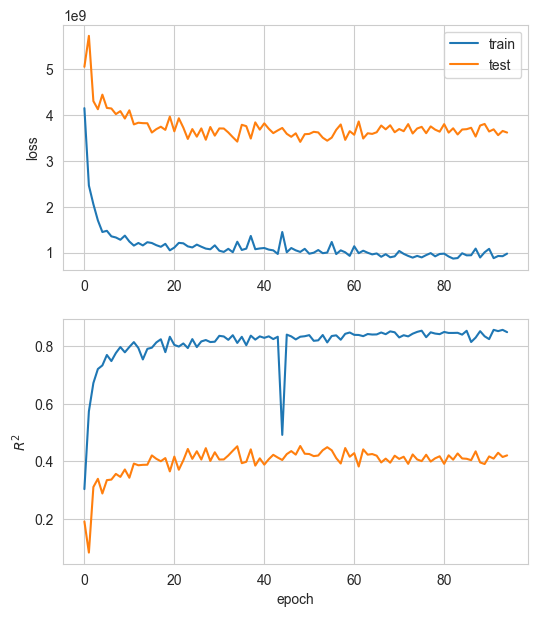

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7))
epochs = torch.arange(len(train_losses[5:]))

axes[0].plot(epochs, train_losses[5:])
axes[0].plot(epochs, test_losses[5:])
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_r2s[5:])
axes[1].plot(epochs, test_r2s[5:])
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("$R^2$");

  R^2: 0.420696
  MSE: 3621411584.000000
 RMSE: 60178.164062
  MAE: 39282.140625
 MAPE: 0.194327
RMSLE: 0.288128


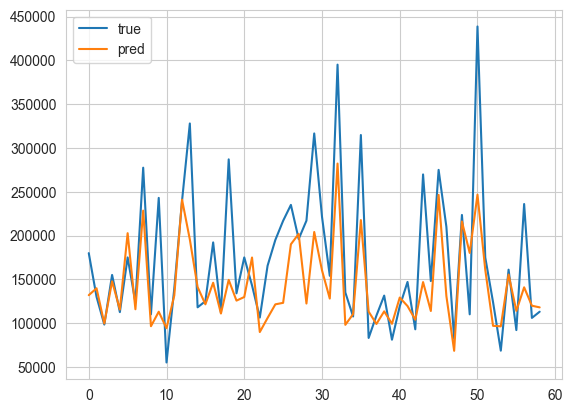

In [75]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)  # тоже самое что и nn.MSELoss
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
print(f"  R^2: {r2:.6f}")
print(f"  MSE: {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f"RMSLE: {rmsle:.6f}")

x = torch.arange(len(y_pred[::5]))
plt.plot(x, y_true[::5])
plt.plot(x, y_pred[::5])
plt.legend(["true", "pred"]);

Качество модели получилось плохим. Есть проблема переобучения (возижно нужно еще больше Dropout). Я думаю, что проблема в данных, а именно в выборе признаков.

## Задание 3

In [76]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

In [77]:
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

masks_dataset = ImageFolder("../data/images/masks", transform=transform)

Выборка относительно неплохо сбалансирована:

with_mask       341
without_mask    275
dtype: int64


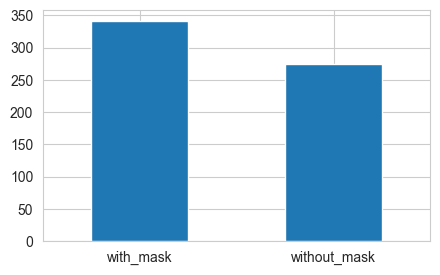

In [78]:
vc = pd.value_counts(masks_dataset.targets)
vc.index = [masks_dataset.classes[i] for i in vc.index]
print(vc)
vc.plot.bar(rot=0, figsize=(5, 3));

Небольшие проблемы с цветами из-за нормализации, но суть задачи ясна - определить есть ли маска на человеке или нет.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


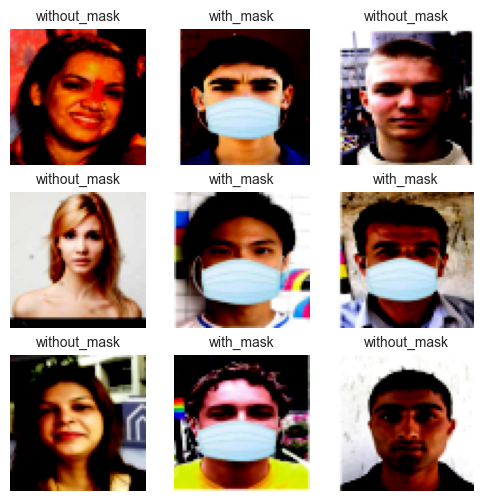

In [79]:
_, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in zip(torch.randperm(len(masks_dataset)), axes.flatten()):
    img, target = masks_dataset[i]
    ax.axis("off")
    ax.set_title(masks_dataset.classes[target], fontdict={"fontsize": 10})
    ax.imshow(img.permute(1, 2, 0))

Разделим выборку на тренировочную и тестовую

In [80]:
test_size = round(0.2 * len(masks_dataset))
train_size = len(masks_dataset) - test_size
train_dataset, test_dataset = random_split(masks_dataset, lengths=(train_size, test_size))

len(train_dataset), len(test_dataset)

(493, 123)

In [81]:
def get_weights(targets):
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(dataloader, model, loss_fn):
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)
    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

In [82]:
class MasksClassifier(nn.Module):

    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [83]:
torch.manual_seed(0)

net = MasksClassifier(
    num_channels=train_dataset[0][0].size(0),
    num_classes=len(masks_dataset.classes),
).to(DEVICE)
weights = get_weights(torch.tensor([target for _, target in train_dataset], device=DEVICE))
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2)

net

MasksClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [84]:
train_losses, train_accuracy_list = [], []
test_losses, test_accuracy_list = [], []

if __name__ == '__main__':
    for epoch in range(5):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss, train_accuracy = train_loop(train_dataloader, net, loss_fn, optimizer)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss, test_accuracy = test_loop(test_dataloader, net, loss_fn)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

Epoch 1
--------------------------------
Train Error: loss: 0.283554, accuracy: 0.8911
 Test Error: loss: 0.165505, accuracy: 0.9268

Epoch 2
--------------------------------
Train Error: loss: 0.111140, accuracy: 0.9718
 Test Error: loss: 0.095436, accuracy: 0.9593

Epoch 3
--------------------------------
Train Error: loss: 0.117287, accuracy: 0.9657
 Test Error: loss: 0.081040, accuracy: 0.9675

Epoch 4
--------------------------------
Train Error: loss: 0.106209, accuracy: 0.9637
 Test Error: loss: 0.116124, accuracy: 0.9431

Epoch 5
--------------------------------
Train Error: loss: 0.078841, accuracy: 0.9819
 Test Error: loss: 0.043719, accuracy: 0.9837



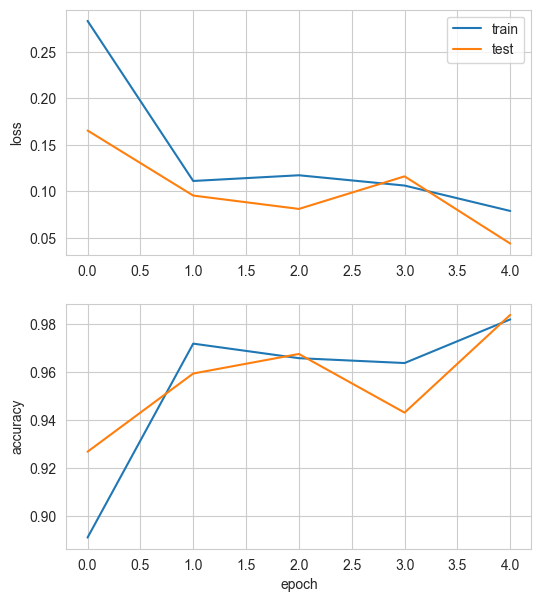

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7))
epochs = torch.arange(len(train_losses))

axes[0].plot(epochs, train_losses)
axes[0].plot(epochs, test_losses)
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_accuracy_list)
axes[1].plot(epochs, test_accuracy_list)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy");

In [86]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

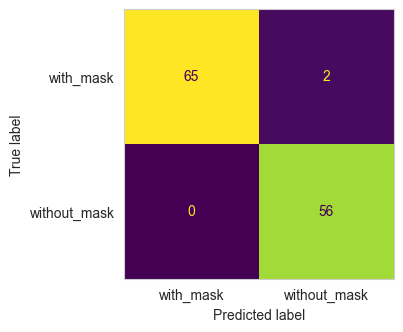

In [87]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=masks_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [88]:
print(metrics.classification_report(y_true, y_pred, target_names=masks_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

   with_mask       1.00      0.97      0.98        67
without_mask       0.97      1.00      0.98        56

    accuracy                           0.98       123
   macro avg       0.98      0.99      0.98       123
weighted avg       0.98      0.98      0.98       123



Качество модели хорошее, однако присутствует проблема переобучения.